# 4.1 Region Growing

## 4.1.1 Connected Threshold 

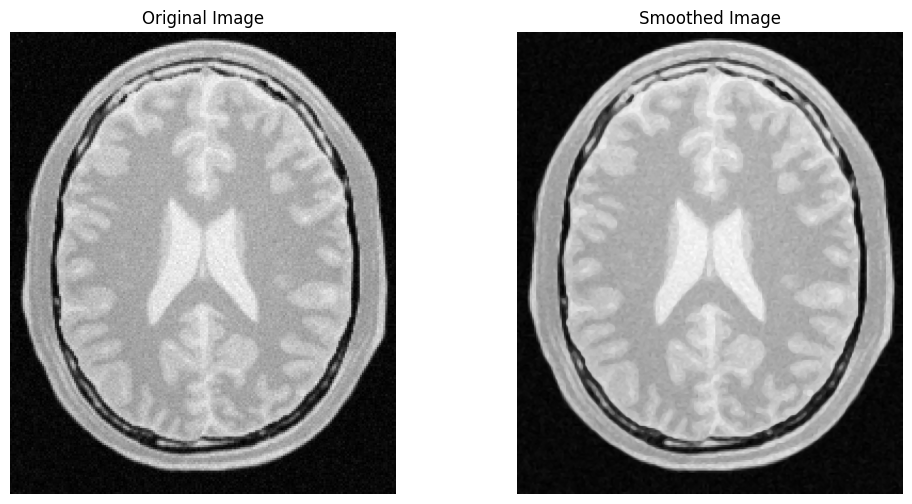

In [98]:
import cv2 as cv
import itk
import numpy as np
import matplotlib.pyplot as plt

# Load the T1-weighted 2D image
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", itk.F)

# Preprocess the image with a smoothing filter
smoothing_filter = itk.CurvatureFlowImageFilter.New(Input=input_image)
smoothing_filter.SetNumberOfIterations(5)
smoothing_filter.SetTimeStep(0.0011)
smoothing_filter.Update()

# Convert ITK images to NumPy arrays for display
original_image_np = itk.GetArrayFromImage(input_image)
smoothed_image_np = itk.GetArrayFromImage(smoothing_filter.GetOutput())

# Display the original and filtered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display smoothed image
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image_np, cmap='gray')
plt.title("Smoothed Image")
plt.axis('off')

plt.show()


White Matter Pixel value at (60, 116): 8.630521774291992
Ventricle Pixel value at (434, 362): 203.02197265625
Gray Matter Pixel value at (107, 69): 9.81052303314209
White Matter Segmented Pixel value at (60, 116): 0.0
Ventricle Segmented Pixel value at (434, 362): 255.0
Gray Matter Segmented Pixel value at (107, 69): 0.0


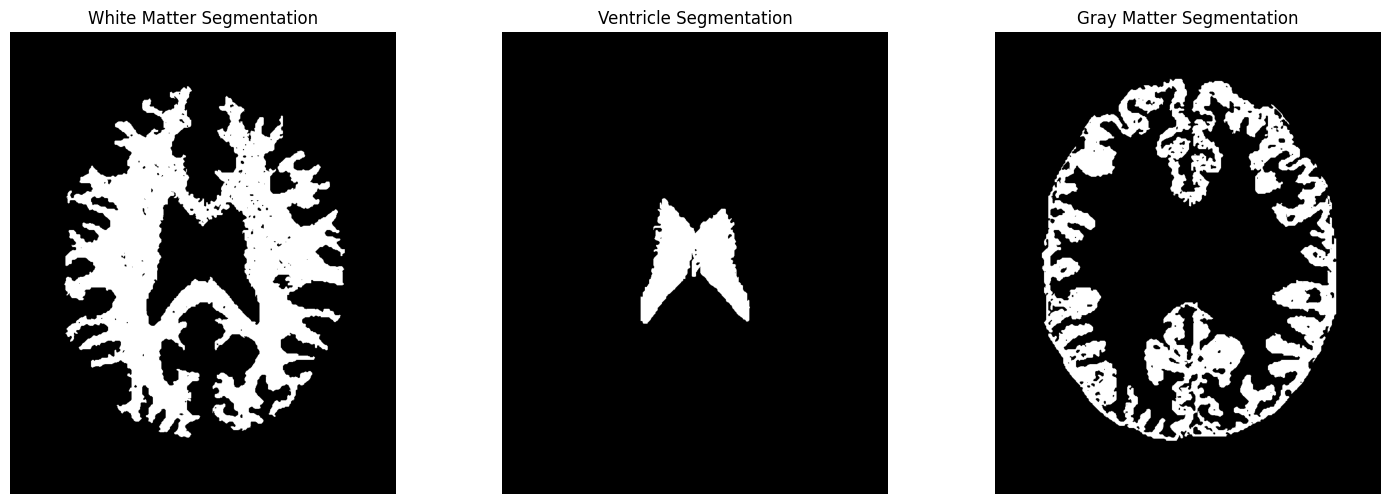

In [9]:
# Function to print pixel value at seed point
def print_pixel_value(image, seed_index, label):
    pixel_value = itk.GetArrayFromImage(image)[seed_index[1], seed_index[0]]  # Note the reversed order for indexing
    print(f"{label} Pixel value at {seed_index}: {pixel_value}")

# Print the original pixel values at each seed point
print_pixel_value(smoothing_filter.GetOutput(), (60, 116), "White Matter")
print_pixel_value(smoothing_filter.GetOutput(), (434, 362), "Ventricle")
print_pixel_value(smoothing_filter.GetOutput(), (107, 69), "Gray Matter")

# Function to apply ConnectedThresholdImageFilter
def apply_connected_threshold(image, seed_index, lower_threshold, upper_threshold):
    connected_threshold_filter = itk.ConnectedThresholdImageFilter.New(Input=image)
    connected_threshold_filter.SetLower(lower_threshold)
    connected_threshold_filter.SetUpper(upper_threshold)
    connected_threshold_filter.SetReplaceValue(255)  # Replace with white color in output

    # Set the seed point
    seed = itk.Index[2]()
    seed.SetElement(0, seed_index[0])
    seed.SetElement(1, seed_index[1])
    connected_threshold_filter.SetSeed(seed)

    # Run the filter
    connected_threshold_filter.Update()
    return connected_threshold_filter.GetOutput()

# Applying the filter to each structure using the smoothed image
white_matter_segmented = apply_connected_threshold(
    smoothing_filter.GetOutput(), 
    seed_index=(434, 320), 
    lower_threshold=150, 
    upper_threshold=180
)

ventricle_segmented = apply_connected_threshold(
    smoothing_filter.GetOutput(), 
    seed_index=(434, 362), 
    lower_threshold=200, 
    upper_threshold=250
)

gray_matter_segmented = apply_connected_threshold(
    smoothing_filter.GetOutput(), 
    seed_index=(170,180), 
    lower_threshold=180, 
    upper_threshold=210
)

# Print the pixel values after segmentation
print_pixel_value(white_matter_segmented, (60, 116), "White Matter Segmented")
print_pixel_value(ventricle_segmented, (434, 362), "Ventricle Segmented")
print_pixel_value(gray_matter_segmented, (107, 69), "Gray Matter Segmented")

# Convert the segmented images to NumPy arrays for display
white_matter_np = itk.GetArrayFromImage(white_matter_segmented)
ventricle_np = itk.GetArrayFromImage(ventricle_segmented)
gray_matter_np = itk.GetArrayFromImage(gray_matter_segmented)

# Display the segmented images
plt.figure(figsize=(18, 6))

# Display White Matter segmentation
plt.subplot(1, 3, 1)
plt.imshow(white_matter_np, cmap='gray')
plt.title("White Matter Segmentation")
plt.axis('off')

# Display Ventricle segmentation
plt.subplot(1, 3, 2)
plt.imshow(ventricle_np, cmap='gray')
plt.title("Ventricle Segmentation")
plt.axis('off')

# Display Gray Matter segmentation
plt.subplot(1, 3, 3)
plt.imshow(gray_matter_np, cmap='gray')
plt.title("Gray Matter Segmentation")
plt.axis('off')

plt.show()


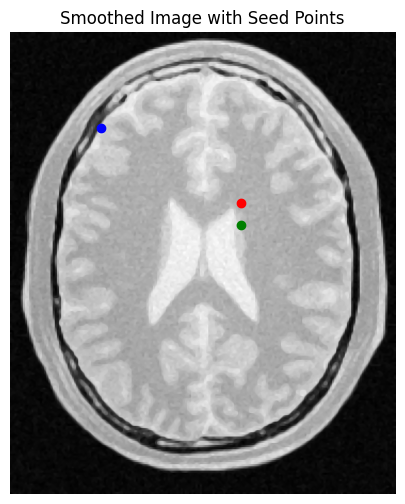

In [102]:
import matplotlib.pyplot as plt

# Overlay function to plot seed points on the image
def overlay_seed_points(image, seed_points, colors):
    plt.imshow(image, cmap='gray')
    for (x, y), color in zip(seed_points, colors):
        plt.plot(x, y, 'o', color=color)
    plt.title("Smoothed Image with Seed Points")
    plt.axis('off')

# Define seed points and corresponding colors
seed_points = [(434, 320), (434, 362), (170,180)]
colors = ['red', 'green', 'blue']

# Display the smoothed image with seed points overlayed
plt.figure(figsize=(6, 6))
overlay_seed_points(smoothed_image_np, seed_points, colors)
plt.show()


### Connected Threshold with mouse marking

In [103]:
import matplotlib.pyplot as plt
import matplotlib

# Overlay function to plot seed points on the image
def overlay_seed_points(image, seed_points, colors):
    plt.imshow(image, cmap='gray')
    for (x, y), color in zip(seed_points, colors):
        plt.plot(x, y, 'o', color=color)
    plt.title("Smoothed Image with Seed Points")
    plt.axis('off')

# Set the backend to TkAgg for a separate window
matplotlib.use('TkAgg')

# List to store seed points and corresponding colors
seed_points = []
colors = ['red', 'green', 'blue']

#Print the color code in single line like red is for white matter, green is for ventricle and blue is for gray matter
print("red : white matter, green : ventricle, blue : gray matter")


# Function to be called when the mouse is clicked
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        if len(seed_points) < 3:  # Allow only three seed points
            # Append the x and y coordinates of the click to seed_points
            seed_points.append((int(event.xdata), int(event.ydata)))
            # Plot the point with the corresponding color
            plt.plot(event.xdata, event.ydata, 'o', color=colors[len(seed_points)-1])
            plt.draw()  # Redraw the figure to show the dot

# Create a figure and display the smoothed image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(smoothed_image_np, cmap='gray')
ax.set_title("Click to select seed points (3 points), then close the window")

# Connect the click event to the on_click function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot in a separate window and block execution until the window is closed
plt.show(block=True)

# Disconnect the event after the figure is closed
fig.canvas.mpl_disconnect(cid)

# Display the smoothed image with selected seed points overlayed
plt.figure(figsize=(6, 6))
overlay_seed_points(smoothed_image_np, seed_points, colors)
plt.show()

# Print the selected seed points
print("Selected seed points:", seed_points)

# Ensure that plots are displayed inline in the notebook
%matplotlib inline

red : white matter, green : ventricle, blue : gray matter
Selected seed points: [(215, 394), (321, 406), (141, 515)]


White Matter Pixel value at (60, 116): 8.630521774291992
Ventricle Pixel value at (434, 362): 203.02197265625
Gray Matter Pixel value at (107, 69): 9.81052303314209
White Matter Segmented Pixel value at (233, 361): 255.0
Ventricle Segmented Pixel value at (317, 432): 255.0
Gray Matter Segmented Pixel value at (230, 139): 0.0


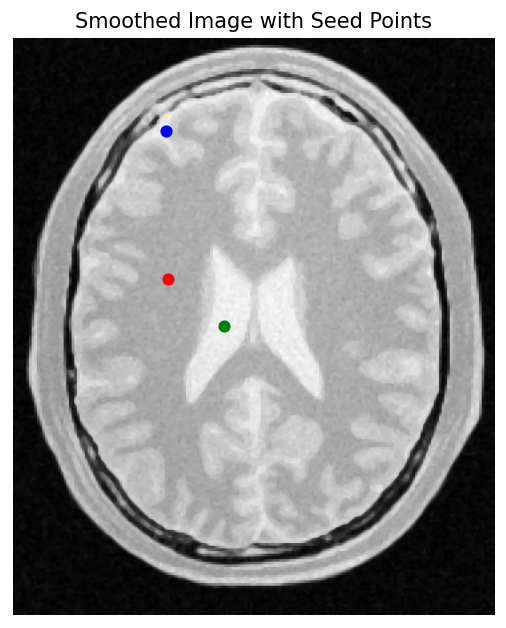

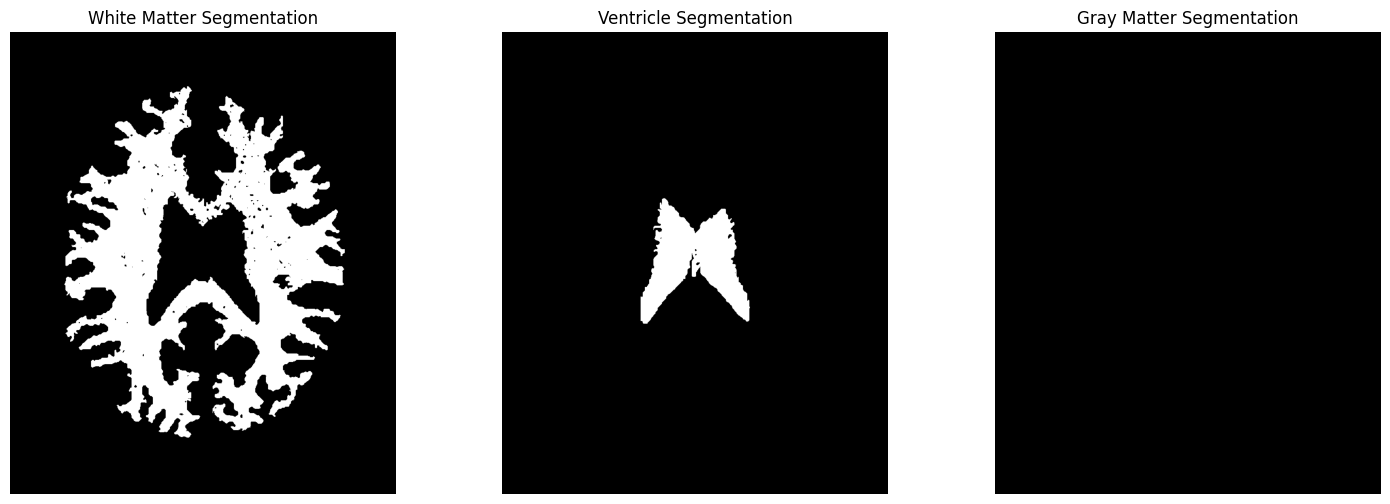

In [12]:
# Function to print pixel value at seed point
def print_pixel_value(image, seed_index, label):
    pixel_value = itk.GetArrayFromImage(image)[seed_index[1], seed_index[0]]  # Note the reversed order for indexing
    print(f"{label} Pixel value at {seed_index}: {pixel_value}")

# Print the original pixel values at each seed point
print_pixel_value(smoothing_filter.GetOutput(), (60, 116), "White Matter")
print_pixel_value(smoothing_filter.GetOutput(), (434, 362), "Ventricle")
print_pixel_value(smoothing_filter.GetOutput(), (107, 69), "Gray Matter")

# Function to apply ConnectedThresholdImageFilter
def apply_connected_threshold(image, seed_index, lower_threshold, upper_threshold):
    connected_threshold_filter = itk.ConnectedThresholdImageFilter.New(Input=image)
    connected_threshold_filter.SetLower(lower_threshold)
    connected_threshold_filter.SetUpper(upper_threshold)
    connected_threshold_filter.SetReplaceValue(255)  # Replace with white color in output

    # Set the seed point
    seed = itk.Index[2]()
    seed.SetElement(0, seed_index[0])
    seed.SetElement(1, seed_index[1])
    connected_threshold_filter.SetSeed(seed)

    # Run the filter
    connected_threshold_filter.Update()
    return connected_threshold_filter.GetOutput()

# Applying the filter to each structure using the smoothed image
white_matter_segmented = apply_connected_threshold(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[0], 
    lower_threshold=150, 
    upper_threshold=180
)

ventricle_segmented = apply_connected_threshold(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[1], 
    lower_threshold=200, 
    upper_threshold=250
)

gray_matter_segmented = apply_connected_threshold(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[2], 
    lower_threshold=180, 
    upper_threshold=210
)

# Print the pixel values after segmentation
print_pixel_value(white_matter_segmented,seed_points[0], "White Matter Segmented")
print_pixel_value(ventricle_segmented,seed_points[1], "Ventricle Segmented")
print_pixel_value(gray_matter_segmented,seed_points[2], "Gray Matter Segmented")

# Convert the segmented images to NumPy arrays for display
white_matter_np = itk.GetArrayFromImage(white_matter_segmented)
ventricle_np = itk.GetArrayFromImage(ventricle_segmented)
gray_matter_np = itk.GetArrayFromImage(gray_matter_segmented)

# Display the segmented images
plt.figure(figsize=(18, 6))

# Display White Matter segmentation
plt.subplot(1, 3, 1)
plt.imshow(white_matter_np, cmap='gray')
plt.title("White Matter Segmentation")
plt.axis('off')

# Display Ventricle segmentation
plt.subplot(1, 3, 2)
plt.imshow(ventricle_np, cmap='gray')
plt.title("Ventricle Segmentation")
plt.axis('off')

# Display Gray Matter segmentation
plt.subplot(1, 3, 3)
plt.imshow(gray_matter_np, cmap='gray')
plt.title("Gray Matter Segmentation")
plt.axis('off')

plt.show()


## 4.1.2. Otsu Segmentation

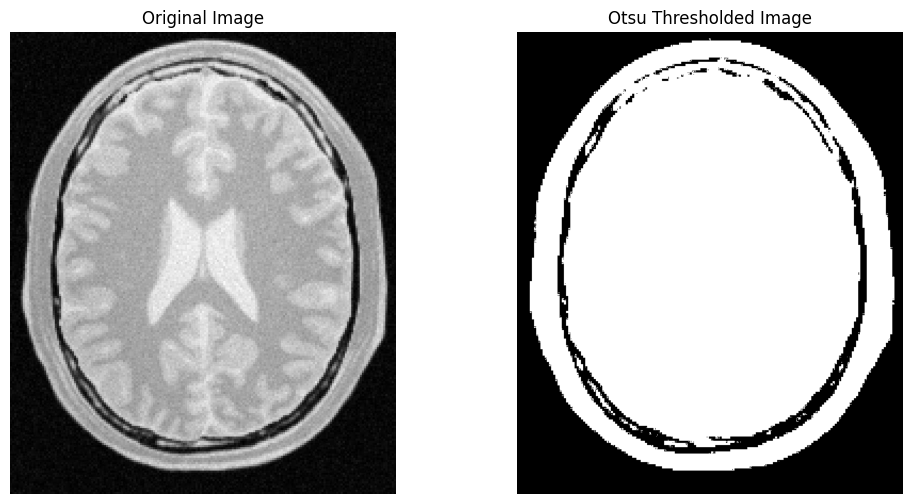

Computed Otsu Threshold Value: 98.61713409423828


In [17]:
import itk
import matplotlib.pyplot as plt

# Load the image using ITK
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", itk.F)

# Apply the Otsu thresholding filter
OtsuFilterType = itk.OtsuThresholdImageFilter[itk.Image[itk.F, 2], itk.Image[itk.UC, 2]]
otsu_filter = OtsuFilterType.New()
otsu_filter.SetInput(input_image)
otsu_filter.SetInsideValue(0)  # Value for the inside of the threshold (e.g., foreground)
otsu_filter.SetOutsideValue(255)   # Value for the outside of the threshold (e.g., background)

# Run the filter
otsu_filter.Update()

# Get the thresholded output
output_image = otsu_filter.GetOutput()

# Convert ITK image to NumPy array for display
output_image_np = itk.GetArrayFromImage(output_image)
input_image_np = itk.GetArrayFromImage(input_image)

# Display the original and Otsu thresholded images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image_np, cmap='gray')
plt.title('Otsu Thresholded Image')
plt.axis('off')

plt.show()

# Print the computed threshold value
otsu_threshold = otsu_filter.GetThreshold()
print(f'Computed Otsu Threshold Value: {otsu_threshold}')


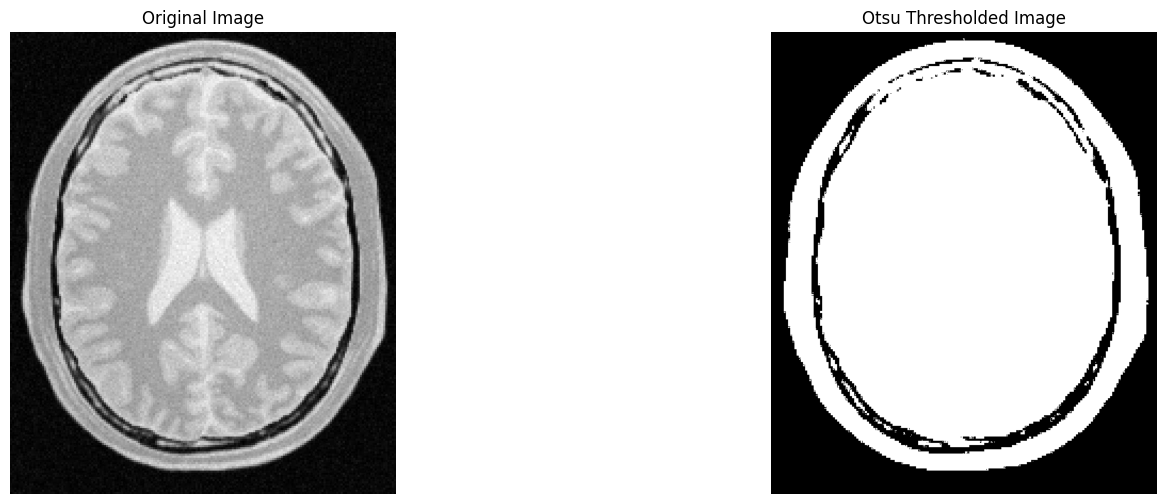

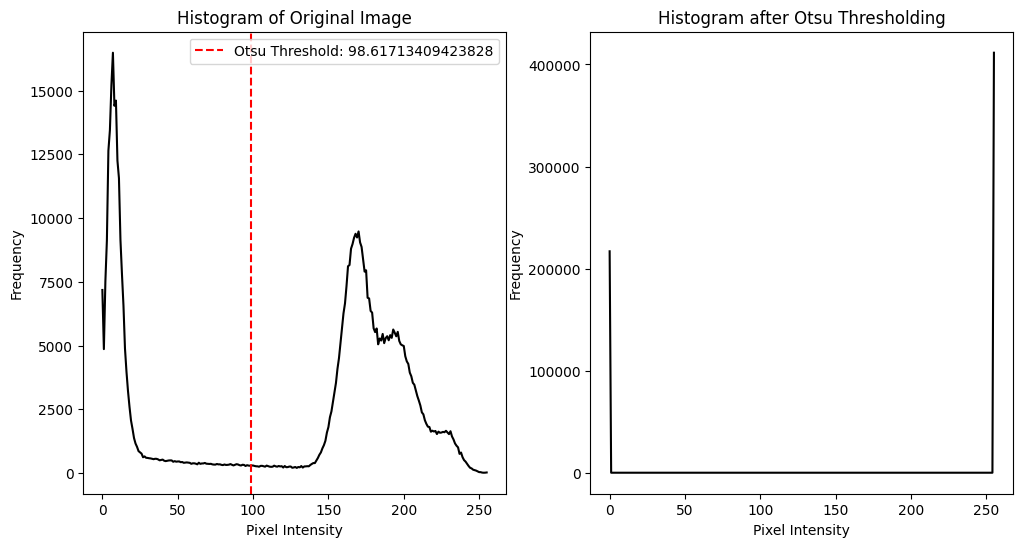

Computed Otsu Threshold Value: 98.61713409423828


In [19]:
import itk
import matplotlib.pyplot as plt
import numpy as np

# Load the image using ITK
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", itk.F)

# Apply the Otsu thresholding filter
OtsuFilterType = itk.OtsuThresholdImageFilter[itk.Image[itk.F, 2], itk.Image[itk.UC, 2]]
otsu_filter = OtsuFilterType.New()
otsu_filter.SetInput(input_image)
otsu_filter.SetInsideValue(0)  # Value for the inside of the threshold (e.g., foreground) Corrected consdering the context of image
otsu_filter.SetOutsideValue(255)   # Value for the outside of the threshold (e.g., background)

# Run the filter
otsu_filter.Update()

# Get the thresholded output
output_image = otsu_filter.GetOutput()

# Convert ITK images to NumPy arrays for display and analysis
input_image_np = itk.GetArrayFromImage(input_image)
output_image_np = itk.GetArrayFromImage(output_image)

# Compute histogram of the original image
hist, bins = np.histogram(input_image_np.flatten(), bins=256, range=[0, 256])

# Compute histogram of the segmented (Otsu thresholded) image
hist_otsu, bins_otsu = np.histogram(output_image_np.flatten(), bins=256, range=[0, 256])

# Get the computed Otsu threshold value
otsu_threshold = otsu_filter.GetThreshold()

# Plot the original image and the thresholded image
plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image_np, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image_np, cmap='gray')
plt.title('Otsu Thresholded Image')
plt.axis('off')

plt.show()

# Plot the histograms and Otsu threshold
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(bins[:-1], hist, color='black')
plt.axvline(otsu_threshold, color='red', linestyle='--', label=f'Otsu Threshold: {otsu_threshold}')
plt.title('Histogram of Original Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(bins_otsu[:-1], hist_otsu, color='black')
plt.title('Histogram after Otsu Thresholding')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

plt.show()

# Print the computed threshold value
print(f'Computed Otsu Threshold Value: {otsu_threshold}')


### Similar methods

Computed Otsu Thresholds: [2.0, 6.0, 32.0, 98.0]


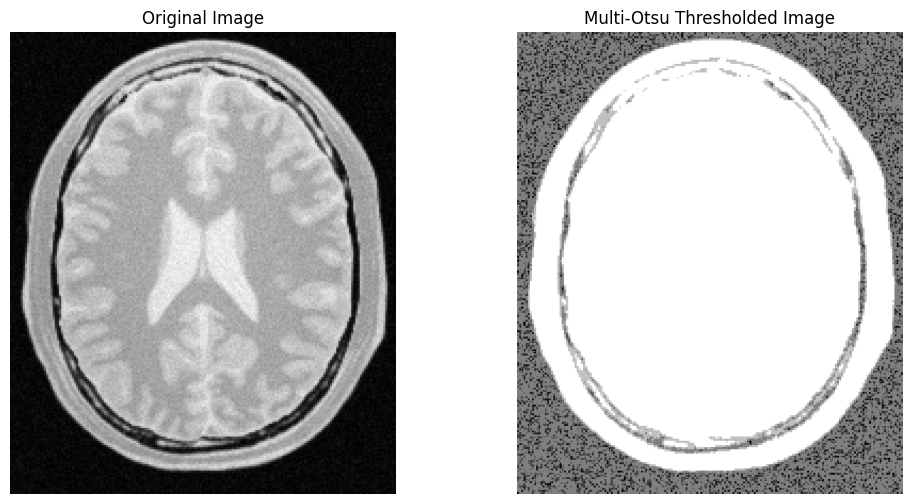

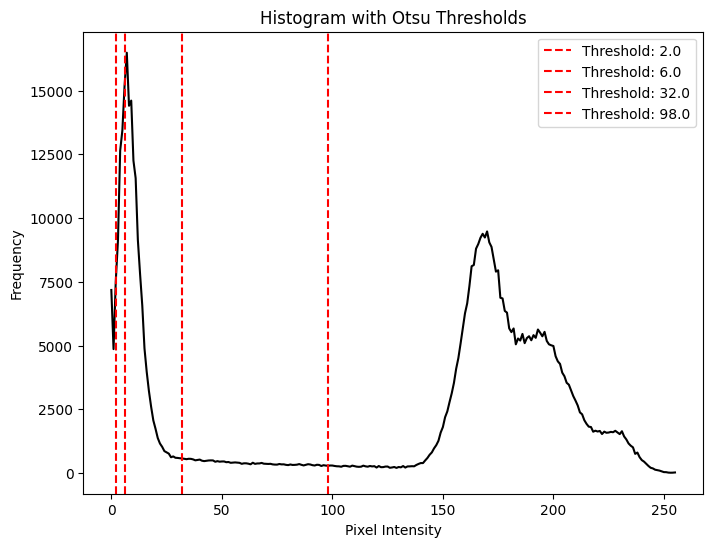

In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image in grayscale
input_image = cv2.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", cv2.IMREAD_GRAYSCALE)

# Calculate multiple Otsu thresholds
def multi_otsu_thresholding(image, num_thresholds):
    # Flatten the image into a 1D array
    pixels = image.flatten()
    
    # Compute the histogram
    hist, bin_edges = np.histogram(pixels, bins=256, range=(0, 256))
    
    # Initialize variables
    thresholds = []
    
    # Apply Otsu's method to find multiple thresholds
    for i in range(num_thresholds):
        threshold, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        thresholds.append(threshold)
        image = np.where(image > threshold, 0, image)
    
    return sorted(thresholds)

# Apply the multi Otsu thresholding
num_thresholds = 4
thresholds = multi_otsu_thresholding(input_image, num_thresholds)
print(f'Computed Otsu Thresholds: {thresholds}')

# Apply the thresholds to segment the image
output_image = np.digitize(input_image, bins=thresholds) * (255 // (num_thresholds + 1))

# Display the original and multi-thresholded images
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Multi-Otsu Thresholded Image')
plt.axis('off')

plt.show()

# Plot histogram with thresholds
hist, bins = np.histogram(input_image.flatten(), bins=256, range=[0, 256])

plt.figure(figsize=(8, 6))
plt.plot(bins[:-1], hist, color='black')
for t in thresholds:
    plt.axvline(t, color='red', linestyle='--', label=f'Threshold: {t}')
plt.title('Histogram with Otsu Thresholds')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.show()


## 4.1.3 Neighborhood Connected

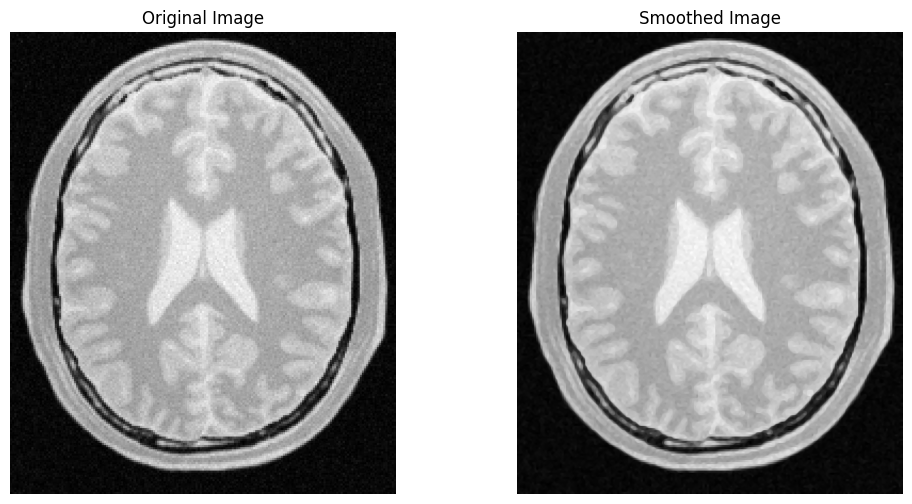

In [24]:
import cv2 as cv
import itk
import numpy as np
import matplotlib.pyplot as plt

# Load the T1-weighted 2D image
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", itk.F)

# Preprocess the image with a smoothing filter
smoothing_filter = itk.CurvatureFlowImageFilter.New(Input=input_image)
smoothing_filter.SetNumberOfIterations(5)
smoothing_filter.SetTimeStep(0.001)
smoothing_filter.Update()

# Convert ITK images to NumPy arrays for display
original_image_np = itk.GetArrayFromImage(input_image)
smoothed_image_np = itk.GetArrayFromImage(smoothing_filter.GetOutput())

# Display the original and filtered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display smoothed image
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image_np, cmap='gray')
plt.title("Smoothed Image")
plt.axis('off')

plt.show()


In [29]:
import matplotlib.pyplot as plt
import matplotlib

# Overlay function to plot seed points on the image
def overlay_seed_points(image, seed_points, colors):
    plt.imshow(image, cmap='gray')
    for (x, y), color in zip(seed_points, colors):
        plt.plot(x, y, 'o', color=color)
    plt.title("Smoothed Image with Seed Points")
    plt.axis('off')

# Set the backend to TkAgg for a separate window
matplotlib.use('TkAgg')

# List to store seed points and corresponding colors
seed_points = []
colors = ['red', 'green', 'blue']

#Print the color code in single line like red is for white matter, green is for ventricle and blue is for gray matter
print("red : white matter, green : ventricle, blue : gray matter")


# Function to be called when the mouse is clicked
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        if len(seed_points) < 3:  # Allow only three seed points
            # Append the x and y coordinates of the click to seed_points
            seed_points.append((int(event.xdata), int(event.ydata)))
            # Plot the point with the corresponding color
            plt.plot(event.xdata, event.ydata, 'o', color=colors[len(seed_points)-1])
            plt.draw()  # Redraw the figure to show the dot

# Create a figure and display the smoothed image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(smoothed_image_np, cmap='gray')
ax.set_title("Click to select seed points (3 points), then close the window")

# Connect the click event to the on_click function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot in a separate window and block execution until the window is closed
plt.show(block=True)

# Disconnect the event after the figure is closed
fig.canvas.mpl_disconnect(cid)

# Display the smoothed image with selected seed points overlayed
plt.figure(figsize=(6, 6))
overlay_seed_points(smoothed_image_np, seed_points, colors)
plt.show()

# Print the selected seed points
print("Selected seed points:", seed_points)

# Ensure that plots are displayed inline in the notebook
%matplotlib inline

red : white matter, green : ventricle, blue : gray matter
Selected seed points: [(224, 385), (326, 400), (149, 500)]


White Matter Pixel value at (224, 385): 173.2947998046875
Ventricle Pixel value at (326, 400): 235.7334442138672
Gray Matter Pixel value at (149, 500): 186.41726684570312
White Matter Segmented Pixel value at (224, 385): 255.0
Ventricle Segmented Pixel value at (326, 400): 255.0
Gray Matter Segmented Pixel value at (149, 500): 255.0


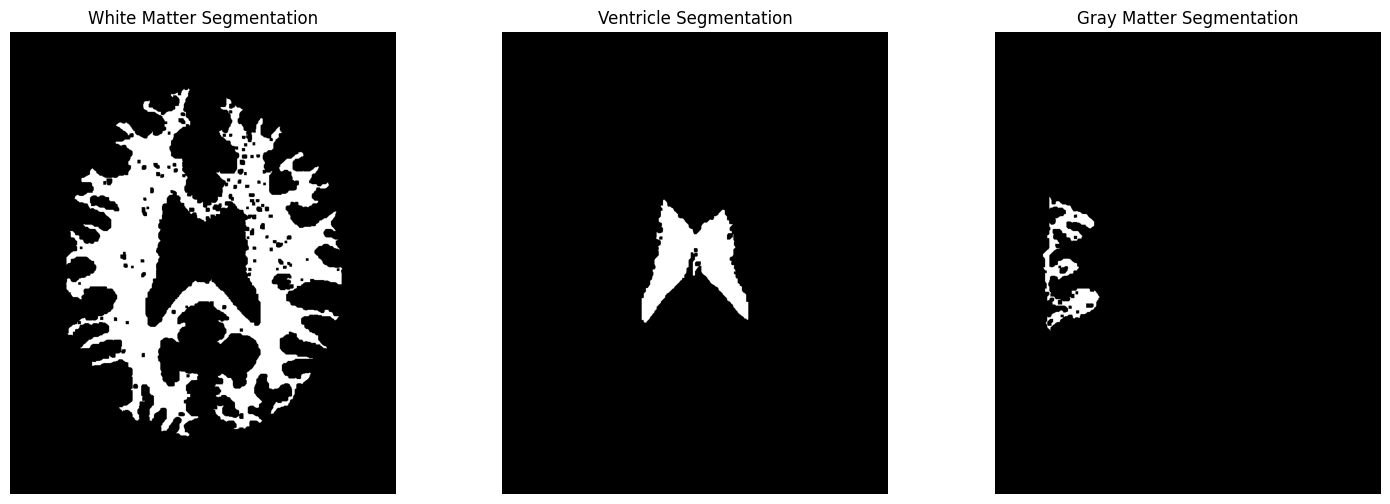

In [34]:
# Function to print pixel value at seed point
def print_pixel_value(image, seed_index, label):
    pixel_value = itk.GetArrayFromImage(image)[seed_index[1], seed_index[0]]  # Note the reversed order for indexing
    print(f"{label} Pixel value at {seed_index}: {pixel_value}")

# Print the original pixel values at each seed point
print_pixel_value(smoothing_filter.GetOutput(),seed_points[0], "White Matter")
print_pixel_value(smoothing_filter.GetOutput(),seed_points[1], "Ventricle")
print_pixel_value(smoothing_filter.GetOutput(),seed_points[2], "Gray Matter")

# Function to apply NeighborhoodConnectedImageFilter
def apply_neighborhood_connected(image, seed_index, lower_threshold, upper_threshold, radius):
    neighborhood_connected_filter = itk.NeighborhoodConnectedImageFilter.New(Input=image)
    neighborhood_connected_filter.SetLower(lower_threshold)
    neighborhood_connected_filter.SetUpper(upper_threshold)
    neighborhood_connected_filter.SetReplaceValue(255)  # Replace with white color in output

    # Set the seed point
    seed = itk.Index[2]()
    seed.SetElement(0, seed_index[0])
    seed.SetElement(1, seed_index[1])
    neighborhood_connected_filter.SetSeed(seed)

    # Set the neighborhood radius
    radius_type = itk.Size[2]()
    radius_type.Fill(radius)  # Apply the same radius in both dimensions
    neighborhood_connected_filter.SetRadius(radius_type)

    # Run the filter
    neighborhood_connected_filter.Update()
    return neighborhood_connected_filter.GetOutput()

# Applying the filter to each structure using the smoothed image
white_matter_segmented = apply_neighborhood_connected(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[0], 
    lower_threshold=150, 
    upper_threshold=180,
    radius=2  # Adjust radius as needed
)

ventricle_segmented = apply_neighborhood_connected(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[1], 
    lower_threshold=200, 
    upper_threshold=250,
    radius=2  # Adjust radius as needed
)

gray_matter_segmented = apply_neighborhood_connected(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[2], 
    lower_threshold=180, 
    upper_threshold=210,
    radius=2  # Adjust radius as needed
)

# Print the pixel values after segmentation
print_pixel_value(white_matter_segmented, seed_points[0], "White Matter Segmented")
print_pixel_value(ventricle_segmented,seed_points[1], "Ventricle Segmented")
print_pixel_value(gray_matter_segmented,seed_points[2], "Gray Matter Segmented")

# Convert the segmented images to NumPy arrays for display
white_matter_np = itk.GetArrayFromImage(white_matter_segmented)
ventricle_np = itk.GetArrayFromImage(ventricle_segmented)
gray_matter_np = itk.GetArrayFromImage(gray_matter_segmented)

# Display the segmented images
plt.figure(figsize=(18, 6))

# Display White Matter segmentation
plt.subplot(1, 3, 1)
plt.imshow(white_matter_np, cmap='gray')
plt.title("White Matter Segmentation")
plt.axis('off')

# Display Ventricle segmentation
plt.subplot(1, 3, 2)
plt.imshow(ventricle_np, cmap='gray')
plt.title("Ventricle Segmentation")
plt.axis('off')

# Display Gray Matter segmentation
plt.subplot(1, 3, 3)
plt.imshow(gray_matter_np, cmap='gray')
plt.title("Gray Matter Segmentation")
plt.axis('off')

plt.show()


## 4.1.4. Confidence Connected

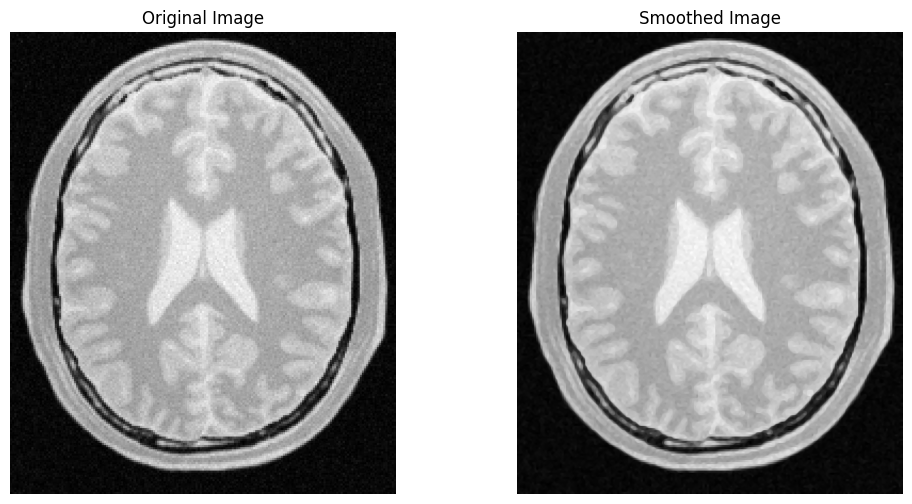

In [35]:
import cv2 as cv
import itk
import numpy as np
import matplotlib.pyplot as plt

# Load the T1-weighted 2D image
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", itk.F)

# Preprocess the image with a smoothing filter
smoothing_filter = itk.CurvatureFlowImageFilter.New(Input=input_image)
smoothing_filter.SetNumberOfIterations(5)
smoothing_filter.SetTimeStep(0.001)
smoothing_filter.Update()

# Convert ITK images to NumPy arrays for display
original_image_np = itk.GetArrayFromImage(input_image)
smoothed_image_np = itk.GetArrayFromImage(smoothing_filter.GetOutput())

# Display the original and filtered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display smoothed image
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image_np, cmap='gray')
plt.title("Smoothed Image")
plt.axis('off')

plt.show()


In [37]:
import matplotlib.pyplot as plt
import matplotlib

# Overlay function to plot seed points on the image
def overlay_seed_points(image, seed_points, colors):
    plt.imshow(image, cmap='gray')
    for (x, y), color in zip(seed_points, colors):
        plt.plot(x, y, 'o', color=color)
    plt.title("Smoothed Image with Seed Points")
    plt.axis('off')

# Set the backend to TkAgg for a separate window
matplotlib.use('TkAgg')

# List to store seed points and corresponding colors
seed_points = []
colors = ['red', 'green', 'blue']

#Print the color code in single line like red is for white matter, green is for ventricle and blue is for gray matter
print("red : white matter, green : ventricle, blue : gray matter")


# Function to be called when the mouse is clicked
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        if len(seed_points) < 3:  # Allow only three seed points
            # Append the x and y coordinates of the click to seed_points
            seed_points.append((int(event.xdata), int(event.ydata)))
            # Plot the point with the corresponding color
            plt.plot(event.xdata, event.ydata, 'o', color=colors[len(seed_points)-1])
            plt.draw()  # Redraw the figure to show the dot

# Create a figure and display the smoothed image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(smoothed_image_np, cmap='gray')
ax.set_title("Click to select seed points (3 points), then close the window")

# Connect the click event to the on_click function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot in a separate window and block execution until the window is closed
plt.show(block=True)

# Disconnect the event after the figure is closed
fig.canvas.mpl_disconnect(cid)

# Display the smoothed image with selected seed points overlayed
plt.figure(figsize=(6, 6))
overlay_seed_points(smoothed_image_np, seed_points, colors)
plt.show()

# Print the selected seed points
print("Selected seed points:", seed_points)

# Ensure that plots are displayed inline in the notebook
%matplotlib inline

red : white matter, green : ventricle, blue : gray matter
Selected seed points: [(496, 382), (320, 406), (161, 487)]


White Matter Pixel value at (496, 382): 172.18832397460938
Ventricle Pixel value at (320, 406): 236.28858947753906
Gray Matter Pixel value at (161, 487): 188.983642578125
White Matter Segmented Pixel value at (496, 382): 255
Ventricle Segmented Pixel value at (320, 406): 255
Gray Matter Segmented Pixel value at (161, 487): 255


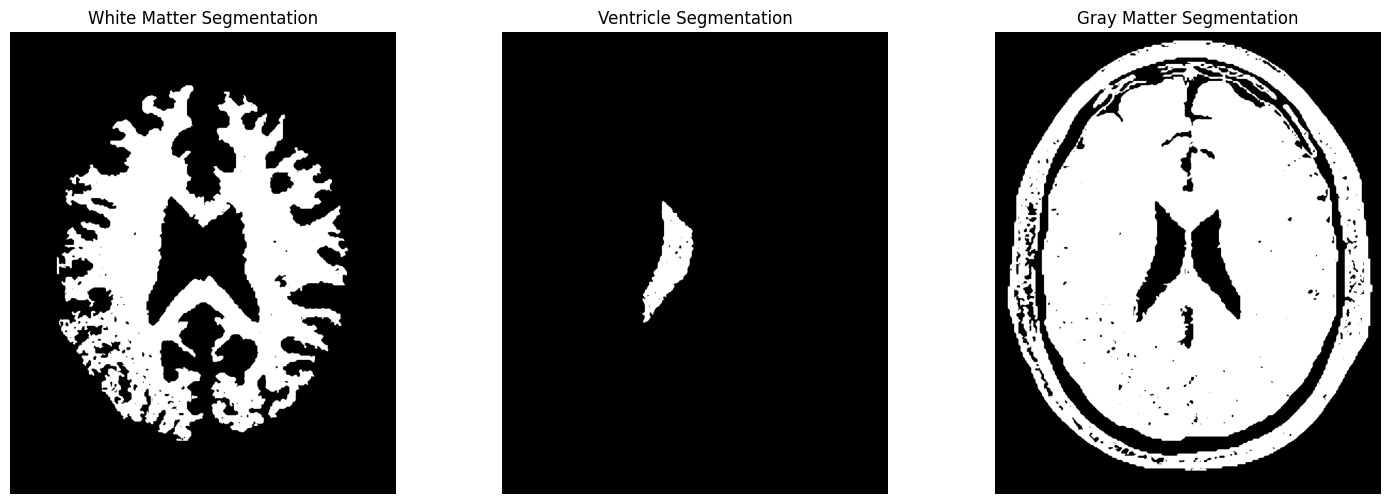

In [39]:
import itk
import matplotlib.pyplot as plt

# Function to print pixel value at seed point
def print_pixel_value(image, seed_index, label):
    pixel_value = itk.GetArrayFromImage(image)[seed_index[1], seed_index[0]]  # Note the reversed order for indexing
    print(f"{label} Pixel value at {seed_index}: {pixel_value}")

# Print the original pixel values at each seed point
print_pixel_value(smoothing_filter.GetOutput(), seed_points[0], "White Matter")
print_pixel_value(smoothing_filter.GetOutput(), seed_points[1], "Ventricle")
print_pixel_value(smoothing_filter.GetOutput(), seed_points[2], "Gray Matter")

# Function to apply ConfidenceConnectedImageFilter
def apply_confidence_connected(image, seed_index, multiplier, iterations, radius):
    confidence_connected_filter = itk.ConfidenceConnectedImageFilter.New(Input=image)
    confidence_connected_filter.SetMultiplier(multiplier)  # The factor to multiply the standard deviation
    confidence_connected_filter.SetNumberOfIterations(iterations)  # Number of iterations
    confidence_connected_filter.SetReplaceValue(255)  # Replace with white color in output
    confidence_connected_filter.SetInitialNeighborhoodRadius(radius)  # Neighborhood radius around the seed

    # Set the seed point
    seed = itk.Index[2]()
    seed.SetElement(0, seed_index[0])
    seed.SetElement(1, seed_index[1])
    confidence_connected_filter.SetSeed(seed)

    # Run the filter
    confidence_connected_filter.Update()
    return confidence_connected_filter.GetOutput()

# Applying the filter to each structure using the smoothed image
white_matter_segmented = apply_confidence_connected(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[0], 
    multiplier=2.5, 
    iterations=5,
    radius=2  # Adjust radius as needed
)

ventricle_segmented = apply_confidence_connected(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[1], 
    multiplier=2.5, 
    iterations=5,
    radius=2  # Adjust radius as needed
)

gray_matter_segmented = apply_confidence_connected(
    smoothing_filter.GetOutput(), 
    seed_index=seed_points[2], 
    multiplier=2.5, 
    iterations=5,
    radius=2  # Adjust radius as needed
)

# Print the pixel values after segmentation
print_pixel_value(white_matter_segmented, seed_points[0], "White Matter Segmented")
print_pixel_value(ventricle_segmented, seed_points[1], "Ventricle Segmented")
print_pixel_value(gray_matter_segmented, seed_points[2], "Gray Matter Segmented")

# Convert the segmented images to NumPy arrays for display
white_matter_np = itk.GetArrayFromImage(white_matter_segmented)
ventricle_np = itk.GetArrayFromImage(ventricle_segmented)
gray_matter_np = itk.GetArrayFromImage(gray_matter_segmented)

# Display the segmented images
plt.figure(figsize=(18, 6))

# Display White Matter segmentation
plt.subplot(1, 3, 1)
plt.imshow(white_matter_np, cmap='gray')
plt.title("White Matter Segmentation")
plt.axis('off')

# Display Ventricle segmentation
plt.subplot(1, 3, 2)
plt.imshow(ventricle_np, cmap='gray')
plt.title("Ventricle Segmentation")
plt.axis('off')

# Display Gray Matter segmentation
plt.subplot(1, 3, 3)
plt.imshow(gray_matter_np, cmap='gray')
plt.title("Gray Matter Segmentation")
plt.axis('off')

plt.show()


### 4.1.5 Isolated Connected

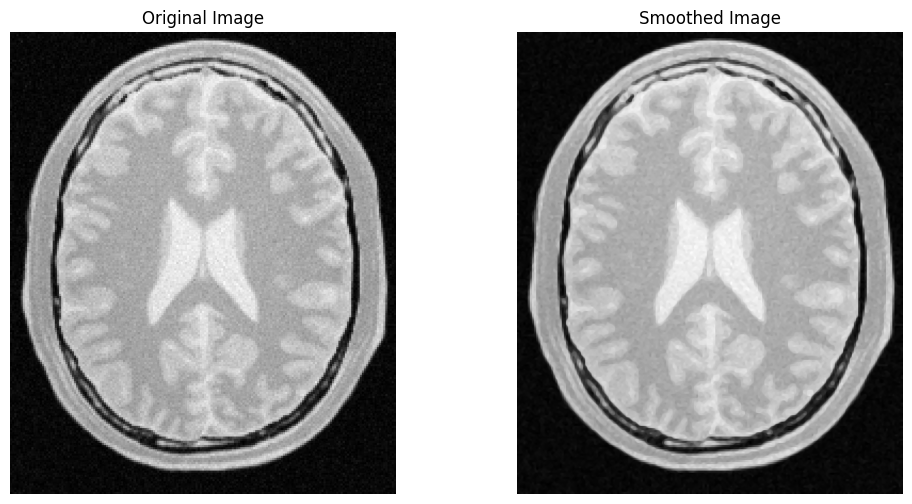

In [40]:
import cv2 as cv
import itk
import numpy as np
import matplotlib.pyplot as plt

# Load the T1-weighted 2D image
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\brainprotondensity.jpg", itk.F)

# Preprocess the image with a smoothing filter
smoothing_filter = itk.CurvatureFlowImageFilter.New(Input=input_image)
smoothing_filter.SetNumberOfIterations(5)
smoothing_filter.SetTimeStep(0.001)
smoothing_filter.Update()

# Convert ITK images to NumPy arrays for display
original_image_np = itk.GetArrayFromImage(input_image)
smoothed_image_np = itk.GetArrayFromImage(smoothing_filter.GetOutput())

# Display the original and filtered images
plt.figure(figsize=(12, 6))

# Display original image
plt.subplot(1, 2, 1)
plt.imshow(original_image_np, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Display smoothed image
plt.subplot(1, 2, 2)
plt.imshow(smoothed_image_np, cmap='gray')
plt.title("Smoothed Image")
plt.axis('off')

plt.show()


In [42]:
import matplotlib.pyplot as plt
import matplotlib

# Overlay function to plot seed points on the image
def overlay_seed_points(image, seed_points, colors):
    plt.imshow(image, cmap='gray')
    for (x, y), color in zip(seed_points, colors):
        plt.plot(x, y, 'o', color=color)
    plt.title("Smoothed Image with Seed Points")
    plt.axis('off')

# Set the backend to TkAgg for a separate window
matplotlib.use('TkAgg')

# List to store seed points and corresponding colors
seed_points = []
colors = ['red', 'blue']

#Print the color code in single line like red is for white matter, green is for ventricle and blue is for gray matter
print("red : white matter,  blue : gray matter")


# Function to be called when the mouse is clicked
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        if len(seed_points) < 2:  # Allow only 2 seed points
            # Append the x and y coordinates of the click to seed_points
            seed_points.append((int(event.xdata), int(event.ydata)))
            # Plot the point with the corresponding color
            plt.plot(event.xdata, event.ydata, 'o', color=colors[len(seed_points)-1])
            plt.draw()  # Redraw the figure to show the dot

# Create a figure and display the smoothed image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(smoothed_image_np, cmap='gray')
ax.set_title("Click to select seed points (2 points), then close the window")

# Connect the click event to the on_click function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot in a separate window and block execution until the window is closed
plt.show(block=True)

# Disconnect the event after the figure is closed
fig.canvas.mpl_disconnect(cid)

# Display the smoothed image with selected seed points overlayed
plt.figure(figsize=(6, 6))
overlay_seed_points(smoothed_image_np, seed_points, colors)
plt.show()

# Print the selected seed points
print("Selected seed points:", seed_points)

# Ensure that plots are displayed inline in the notebook
%matplotlib inline

red : white matter,  blue : gray matter
Selected seed points: [(236, 408), (153, 509)]


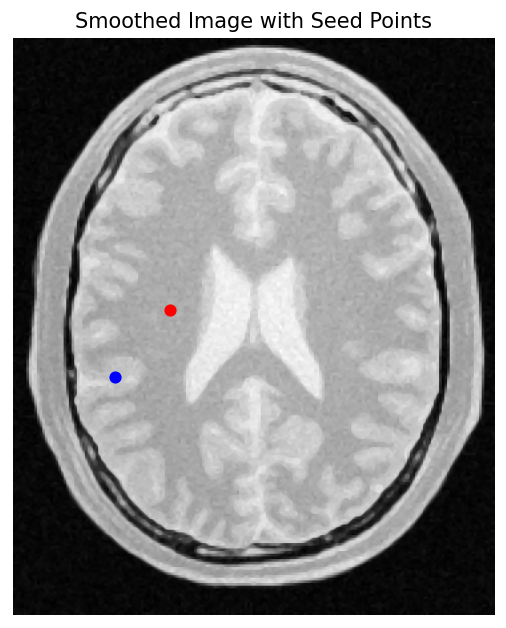

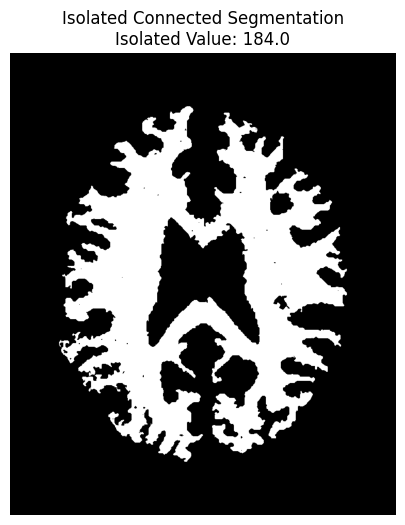

Isolated Value Found: 184.0


In [43]:
import itk
import matplotlib.pyplot as plt

# Function to apply IsolatedConnectedImageFilter
def apply_isolated_connected(image, seed1, seed2, lower_threshold):
    isolated_connected_filter = itk.IsolatedConnectedImageFilter.New(Input=image)
    isolated_connected_filter.SetLower(lower_threshold)

    # Set the first seed point
    seed_index1 = itk.Index[2]()
    seed_index1.SetElement(0, seed1[0])
    seed_index1.SetElement(1, seed1[1])
    isolated_connected_filter.AddSeed1(seed_index1)

    # Set the second seed point
    seed_index2 = itk.Index[2]()
    seed_index2.SetElement(0, seed2[0])
    seed_index2.SetElement(1, seed2[1])
    isolated_connected_filter.AddSeed2(seed_index2)

    # Set the value to replace the region with
    isolated_connected_filter.SetReplaceValue(255)

    # Run the filter
    isolated_connected_filter.Update()
    return isolated_connected_filter.GetOutput(), isolated_connected_filter.GetIsolatedValue()

# Define the seed points and lower threshold
seed_point1 = seed_points[0]# Example seed 1 coordinates
seed_point2 = seed_points[1]   # Example seed 2 coordinates
lower_threshold = 150    # Example lower threshold

# Apply the IsolatedConnectedImageFilter
segmented_image, isolated_value = apply_isolated_connected(
    smoothing_filter.GetOutput(), 
    seed1=seed_point1, 
    seed2=seed_point2, 
    lower_threshold=lower_threshold
)

# Convert the segmented image to a NumPy array for display
segmented_image_np = itk.GetArrayFromImage(segmented_image)

# Display the segmented image
plt.figure(figsize=(6, 6))
plt.imshow(segmented_image_np, cmap='gray')
plt.title(f"Isolated Connected Segmentation\nIsolated Value: {isolated_value}")
plt.axis('off')
plt.show()

# Print the isolated value found by the filter
print(f"Isolated Value Found: {isolated_value}")


## 4.1.6 Vector Confidence Connected filter

$$
d_M(\mathbf{x}) = \sqrt{(\mathbf{x} - \mathbf{\mu})^T \mathbf{\Sigma}^{-1} (\mathbf{x} - \mathbf{\mu})}
$$



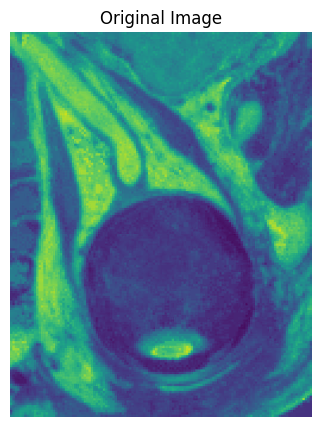

In [1]:
import itk
import matplotlib.pyplot as plt

# Load the T1-weighted image
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\eyeball.jpg", itk.F)

# Define the slice index before using it
slice_index = 37  # Adjust this index to the slice you want to inspect

#itk.GetArrayFromImage(input_image)[slice_index, :, :] save it in a variable 
original_image_slice=itk.GetArrayFromImage(input_image)

# Plot the original and segmented images of the specified slice
plt.figure(figsize=(10, 5))

plt.title('Original Image')
plt.imshow(itk.GetArrayFromImage(input_image))
plt.axis('off')
plt.show()


In [2]:
import matplotlib.pyplot as plt
import matplotlib

# Overlay function to plot seed points on the image
def overlay_seed_points(image, seed_points, colors):
    plt.imshow(image, cmap='gray')
    for (x, y), color in zip(seed_points, colors):
        plt.plot(x, y, 'o', color=color)
    plt.title("Smoothed Image with Seed Points")
    plt.axis('off')

# Set the backend to TkAgg for a separate window
matplotlib.use('TkAgg')

# List to store seed points and corresponding colors
seed_points = []
colors = ['red', 'blue']

#Print the color code in single line like red is for white matter, green is for ventricle and blue is for gray matter
# print("red : white matter,  blue : gray matter")


# Function to be called when the mouse is clicked
def on_click(event):
    if event.xdata is not None and event.ydata is not None:
        if len(seed_points) < 2:  # Allow only 2 seed points
            # Append the x and y coordinates of the click to seed_points
            seed_points.append((int(event.xdata), int(event.ydata)))
            # Plot the point with the corresponding color
            plt.plot(event.xdata, event.ydata, 'o', color=colors[len(seed_points)-1])
            plt.draw()  # Redraw the figure to show the dot

# Create a figure and display the smoothed image
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow((itk.GetArrayFromImage(input_image)))
ax.set_title("Click to select seed points (2 points), then close the window")

# Connect the click event to the on_click function
cid = fig.canvas.mpl_connect('button_press_event', on_click)

# Show the plot in a separate window and block execution until the window is closed
plt.show(block=True)

# Disconnect the event after the figure is closed
fig.canvas.mpl_disconnect(cid)

# # Display the smoothed image with selected seed points overlayed
# plt.figure(figsize=(6, 6))
# overlay_seed_points(smoothed_image_np, seed_points, colors)
# plt.show()

# Print the selected seed points
print("Selected seed points:", seed_points)

# Ensure that plots are displayed inline in the notebook
%matplotlib inline

Selected seed points: [(266, 412), (28, 287)]


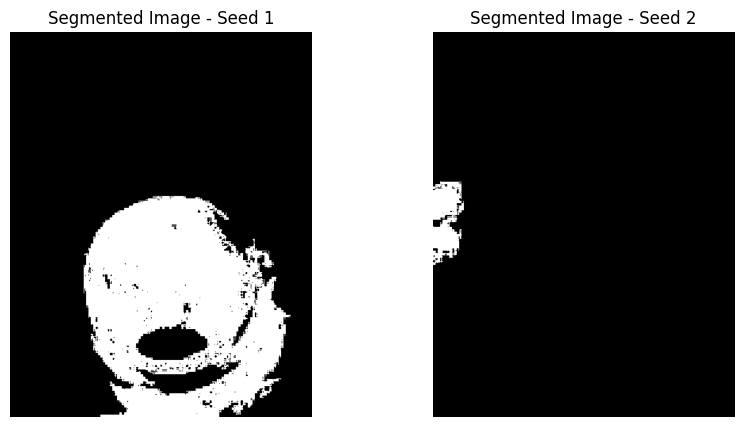

In [78]:
import itk
import matplotlib.pyplot as plt

# Function to apply ConfidenceConnectedImageFilter for a single seed
def apply_confidence_connected(input_image, seed_point, slice_index, multiplier=2.5, iterations=5):
    confidence_connected_filter = itk.ConfidenceConnectedImageFilter.New(Input=input_image)
    confidence_connected_filter.SetMultiplier(multiplier)
    confidence_connected_filter.SetNumberOfIterations(iterations)
    confidence_connected_filter.SetReplaceValue(255)

    # Set the seed point (including the slice index for the third dimension)
    itk_seed = itk.Index[2]()  # 3D index
    itk_seed.SetElement(0, seed_point[0])
    itk_seed.SetElement(1, seed_point[1])
    #itk_seed.SetElement(2, slice_index)  # Specify the slice index
    confidence_connected_filter.AddSeed(itk_seed)

    # Apply the filter
    confidence_connected_filter.Update()

    # Extract the segmented image slice
    segmented_image = confidence_connected_filter.GetOutput()
    segmented_image_slice = itk.GetArrayFromImage(segmented_image)#[slice_index, :, :]

    return segmented_image_slice

# Plot each segmentation separately
plt.figure(figsize=(10, 5))
for i, seed in enumerate(seed_points):
    segmented_slice = apply_confidence_connected(input_image, seed, slice_index)
    
    plt.subplot(1, len(seed_points), i+1)
    plt.title(f'Segmented Image - Seed {i+1}')
    plt.imshow(segmented_slice, cmap='gray')
    plt.axis('off')

plt.show()


## 4.2. Watershed Segmentation

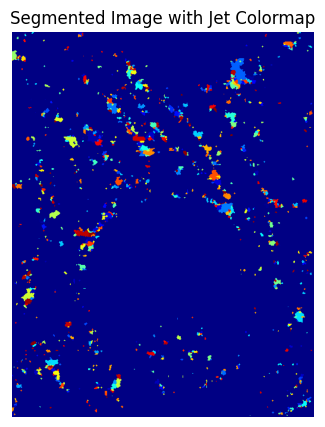

In [10]:
import itk
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the RGB image
input_image = itk.imread(r"D:\work\UoM\sem 7\Medical Image Processing\My Presentation\eyeball.jpg")

# Convert RGB image to grayscale (since watershed operates on scalar images)
grayscale_filter = itk.RGBToLuminanceImageFilter.New(Input=input_image)
grayscale_filter.Update()
grayscale_image = grayscale_filter.GetOutput()

# Cast the grayscale image to the expected type
cast_filter = itk.CastImageFilter[itk.Image[itk.UC, 2], itk.Image[itk.F, 2]].New(Input=grayscale_image)
cast_filter.Update()
cast_image = cast_filter.GetOutput()

# Smooth the image using CurvatureFlowImageFilter
smoothing_filter = itk.CurvatureFlowImageFilter.New(Input=cast_image)
smoothing_filter.SetNumberOfIterations(5)
smoothing_filter.SetTimeStep(0.125)
smoothing_filter.Update()

# Compute the gradient magnitude
gradient_filter = itk.GradientMagnitudeImageFilter.New(Input=smoothing_filter.GetOutput())
gradient_filter.Update()

# Apply the watershed filter
watershed_filter = itk.WatershedImageFilter.New(Input=gradient_filter.GetOutput())
watershed_filter.SetThreshold(0.00001)  # Controls over-segmentation
watershed_filter.SetLevel(0.25)       # Controls the granularity of segmentation
watershed_filter.Update()

# Convert the labeled image to a NumPy array
labeled_image = itk.GetArrayFromImage(watershed_filter.GetOutput()).astype(np.uint8)

# Apply the Jet colormap using cv2
colored_image = cv2.applyColorMap(labeled_image, cv2.COLORMAP_JET)

# Display the result
plt.figure(figsize=(10, 5))
plt.title('Segmented Image with Jet Colormap')
plt.imshow(cv2.cvtColor(colored_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
